<a href="https://colab.research.google.com/github/Meta-Sean/Practical-Deep-Learning/blob/main/corncomp_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle fastkaggle fastai timm>=0.6.2.dev0 

In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle #creating folder
! cp kaggle.json ~/.kaggle/ #copying kaggle.json
! chmod 600 ~/.kaggle/kaggle.json #reading the file with full access

In [ ]:
from fastkaggle import * 

comp = 'kaggle-pog-series-s01e03'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

100%|██████████| 491M/491M [00:36<00:00, 14.1MB/s]

In [ ]:
from pathlib import Path
path = Path('/content/kaggle-pog-series-s01e03/corn/')
path

Path('/content/kaggle-pog-series-s01e03/corn')

In [ ]:
from fastai.vision.all import *

path.ls()

(#5) [Path('/content/kaggle-pog-series-s01e03/corn/train.csv'),Path('/content/kaggle-pog-series-s01e03/corn/test'),Path('/content/kaggle-pog-series-s01e03/corn/train'),Path('/content/kaggle-pog-series-s01e03/corn/test.csv'),Path('/content/kaggle-pog-series-s01e03/corn/sample_submission.csv')]

In [ ]:
trn_path = path/'train'
files = get_image_files(trn_path)
files

(#14322) [Path('/content/kaggle-pog-series-s01e03/corn/train/06857.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/10127.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/04699.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/03647.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/16700.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/01480.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/07305.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/17475.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/12232.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/01078.png')...]

In [ ]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [ ]:
#resize_images(path/'train', dest=trn_path, max_size=184, recurse=True)

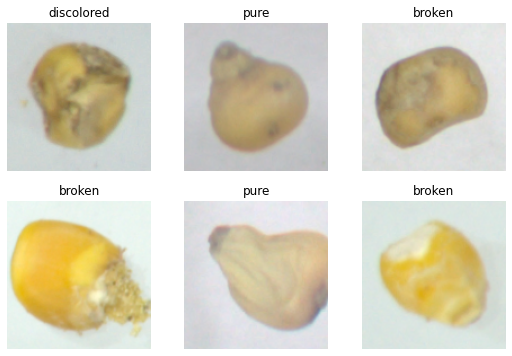

In [ ]:
dls = ImageDataLoaders.from_csv(path, 'train.csv', fn_col=2, label_col=3, item_tfms=Resize((132, 128)))
dls.show_batch(max_n=6)

In [ ]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_csv(path, 'train.csv', fn_col=2, label_col=3, item_tfms=item,
                                   batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=[error_rate, accuracy]).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [ ]:
learn = train('resnet26d', item=Resize(132), batch=aug_transforms(size=112, flip_vert=True))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,23:24


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,32:40
1,0.000000,0.000000,0.000000,33:31
2,0.000000,0.000000,0.000000,32:52
3,0.000000,0.000000,0.000000,32:47
4,0.000000,0.000000,0.000000,32:14


# ConvNeXt model

In [ ]:
arch = 'convnext_small_in22k'

Squish

In [ ]:
learn = train(arch, item=Resize(132, method='squish'), batch=aug_transforms(size=112, min_scale=0.75))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.022829,0.888675,0.340433,0.659567,00:43


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.699785,0.653847,0.255587,0.744413,00:51
1,0.656805,0.603602,0.240922,0.759078,00:51
2,0.548675,0.538513,0.212640,0.787360,00:52
3,0.450891,0.522502,0.208101,0.791899,00:52
4,0.363199,0.532447,0.206704,0.793296,00:51


Crop

In [40]:
learn = train(arch, item=Resize(132),
              batch=aug_transforms(size=112, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.046260,0.851711,0.322626,0.677374,00:43


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.734800,0.637860,0.261173,0.738827,00:51
1,0.666268,0.591436,0.228701,0.771299,00:51
2,0.560615,0.623496,0.243366,0.756634,00:51
3,0.471910,0.502056,0.198324,0.801676,00:52
4,0.394025,0.487822,0.193785,0.806215,00:51


Padding

In [ ]:
# learn = train(arch, item=Resize((132,128), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
#       batch=aug_transforms(size=(171,128), min_scale=0.75))

Test time augmentation

In [ ]:
valid = learn.dls.valid
preds, targs = learn.get_preds(dl=valid)

In [ ]:
error_rate(preds, targs)

TensorBase(0.2008)

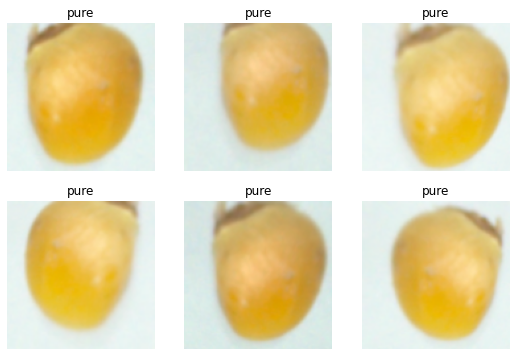

In [ ]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [ ]:
tta_preds,_ = learn.tta(dl=valid)

In [ ]:
error_rate(tta_preds, targs)

TensorBase(0.1973)

In [ ]:
learn = train(arch, item=Resize(184, method='squish'), batch=aug_transforms(size=112, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.035709,0.837009,0.319483,0.680517,00:45


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.712797,0.685730,0.266061,0.733939,00:54
1,0.636423,0.678709,0.252444,0.747556,00:56
2,0.545350,0.555162,0.220670,0.779330,00:54
3,0.442197,0.512161,0.200070,0.799930,00:54
4,0.365678,0.530849,0.203911,0.796089,00:55


In [ ]:
learn = train('convnext_nano', epochs=12, item=Resize(132, method='squish'), batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/convnext_nano_d1h-7eb4bdea.pth" to /root/.cache/torch/hub/checkpoints/convnext_nano_d1h-7eb4bdea.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.171225,1.021746,0.384078,0.615922,00:37


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.777886,0.675970,0.263617,0.736383,00:41
1,0.682584,0.699573,0.282472,0.717528,00:41
2,0.669096,0.623302,0.250698,0.749302,00:42
3,0.594927,0.673610,0.263966,0.736033,00:42
4,0.525301,0.580933,0.232891,0.767109,00:41
5,0.471146,0.631801,0.232193,0.767807,00:41
6,0.410835,0.745407,0.257332,0.742668,00:41
7,0.335970,0.623249,0.217528,0.782472,00:42
8,0.264412,0.685903,0.215782,0.784218,00:43
9,0.207352,0.766662,0.222067,0.777933,00:42


In [41]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.1910)

In [42]:
tst_files = get_image_files(path/'test').sorted()
tst_dl = dls.test_dl(tst_files)

In [43]:
preds,_ = learn.tta(dl=tst_dl)

In [44]:
idxs = preds.argmax(dim=1)

In [45]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [46]:
ss = pd.read_csv(path/'sample_submission.csv')
ss = ss['seed_id']
tst_df = pd.read_csv(path/'test.csv')
tst_df
ss

0        8632
1       11394
2       17362
3        9987
4       17226
        ...  
3474     1461
3475     2566
3476    11504
3477     5140
3478     6025
Name: seed_id, Length: 3479, dtype: int64

In [47]:
tst_df['label'] = results
tst_df

,seed_id,view,image,label
0,2,top,test/00002.png,pure
1,11,bottom,test/00011.png,pure
2,13,top,test/00013.png,pure
3,19,bottom,test/00019.png,broken
4,27,bottom,test/00027.png,pure
...,...,...,...,...
3474,17775,bottom,test/17775.png,pure
3475,17781,bottom,test/17781.png,broken
3476,17790,bottom,test/17790.png,pure
3477,17794,bottom,test/17794.png,pure


In [48]:
ss = pd.merge(ss, tst_df, on="seed_id")
ss

,seed_id,view,image,label
0,8632,bottom,test/08632.png,broken
1,11394,bottom,test/11394.png,broken
2,17362,bottom,test/17362.png,broken
3,9987,top,test/09987.png,broken
4,17226,top,test/17226.png,pure
...,...,...,...,...
3474,1461,top,test/01461.png,silkcut
3475,2566,top,test/02566.png,silkcut
3476,11504,top,test/11504.png,silkcut
3477,5140,bottom,test/05140.png,broken


In [49]:
ss = ss[["seed_id", "label"]]
ss

,seed_id,label
0,8632,broken
1,11394,broken
2,17362,broken
3,9987,broken
4,17226,pure
...,...,...
3474,1461,silkcut
3475,2566,silkcut
3476,11504,silkcut
3477,5140,broken


In [50]:
ss.to_csv('submission.csv', index=False)
!head submission.csv

seed_id,label
8632,broken
11394,broken
17362,broken
9987,broken
17226,pure
17100,pure
968,broken
4069,broken
8505,broken
